# Data preprocessing

In [2]:
import os
from tqdm import tqdm

In [ ]:
!unzip /content/drive/MyDrive/audio.zip #your audios here

In [4]:
import pandas as pd
df = pd.read_csv('/content/dia_data.csv') #your dataset

In [5]:
df['fpath'] = '/content/audio_to_release/' + df['lang'] + '/' + df['source']

In [6]:
df['fpath'] = df['fpath'].apply(lambda x: x.replace(' ', '_')) #removing spaces in dataset's paths

In [7]:
all_paths = df['fpath']
all_paths = list(set(all_paths))

In [9]:
df = df.reset_index() #adding indexes(id)

In [ ]:
df2 = pd.DataFrame(df.drop(['speaker', 'source', 'lang', 'index'], axis=1).groupby('fpath').apply(dict)).reset_index()
df2['coord_start'] = df2[0].apply(lambda x: x['start'])
df2['coord_end'] = df2[0].apply(lambda x: list(x['end'])[-1])
df2

In [ ]:
dict_coord = df2.set_index('fpath').T.to_dict('list')

In [ ]:
def cutter(fpath, start, stop, index): #cutting files accroding to timecodes
  !ffmpeg -i {fpath} -ss {str(start)} -to {str(stop)} -ar 16000 {index}.wav

In [ ]:
from tqdm import tqdm
for i in tqdm(dict_coord):
  cutter(i, dict_coord[i][1], dict_coord[i][2], i)
  #print(i, int(dict_coord[i][1]), dict_coord[i][2])

In [ ]:
dir_name = "/content/audio_to_release" #getting rid of large files

def remover(directory):
  for item in os.listdir(directory):
    if (not '.wav.wav' in item) and (not '.mp4.wav' in item) and (not '.WAV.wav' in item):
      os.remove(os.path.join(directory, item))

In [ ]:
dirs = os.listdir(dir_name) 
for i in range(len(dirs)):
  dirs[i] = "/content/audio_to_release/" + dirs[i]

In [ ]:
for item in dirs:
  remover(item)

In [ ]:
def replacer(fpath): #new paths in dataframe's column 'fpath' according to new file names
  fpath = fpath.replace('.wav', '.wav.wav').replace('.mp4', '.mp4.wav').replace('.WAV', '.WAV.wav')
  return fpath

In [ ]:
df['fpath'] = df['fpath'].apply(replacer)

In [ ]:
df

In [ ]:
all_paths = set(list(df['fpath']))

In [ ]:
print(all_paths)

# New shape for dataset

In [26]:
path_dict = {}
for idx, row in df.iterrows():
    if row['fpath'] in path_dict:
        if row['speaker'] in path_dict[row['fpath']]:
            path_dict[row['fpath']][row['speaker']]['start'].append(row['start'])
            path_dict[row['fpath']][row['speaker']]['end'].append(row['end'])
        else:
            path_dict[row['fpath']][row['speaker']] = {'start': [row['start']], 'end' : [row['end']]}
    else:
        path_dict[row['fpath']] = {row['speaker']: {'start': [row['start']], 'end' : [row['end']]}}

In [ ]:
print(path_dict)

In [28]:
path_dict_new = {}
for path in path_dict.keys():
    path_dict_new[path] = {}
    for speaker in path_dict[path].keys():
        path_dict_new[path][speaker] = {}
        times = path_dict[path][speaker]
        for i in range(1, len(times['start'])+1):
            path_dict_new[path][speaker][i] = [times['start'][i-1], times['end'][i-1]]

In [ ]:
print(path_dict_new.items())

In [30]:
new_df = pd.DataFrame(path_dict_new.items(), columns=['file_path', 'source_data'])

In [ ]:
new_df

In [ ]:
new_df['speakers'] = new_df['source_data'].apply(len)
new_df

In [33]:
new_df.to_csv('new_shape.csv')

# Diarization

In [ ]:
!pip install pyannote.audio pyannote.core
!pip install pydub

In [ ]:
from pyannote.audio.features import RawAudio
from IPython.display import Audio
from sklearn.cluster import KMeans
from pyannote.core import Segment, notebook
import torch

In [ ]:
from pyannote.audio.features import RawAudio
from IPython.display import Audio

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

#clusterer = KMeans(n_clusters=2)
pipeline = torch.hub.load('pyannote/pyannote-audio', 'dia', device=device)

def max_loudness_of_segment(seg, waveform, nmax=1):
  try:
    notebook.crop = seg
    plot = waveform.crop(seg, return_data=False)
    return pd.Series(plot.data.squeeze()).abs().sort_values().tail(nmax).mean()
  except Exception as e:
    print(e, waveform)
    

In [ ]:
def diarizator(fpath, speakers): #diarization function
  try:
    clusterer = KMeans(n_clusters=int(speakers))
    OWN_FILE = {'audio': fpath}
    waveform = RawAudio()(OWN_FILE)
    print(waveform)
    diarization = pipeline(OWN_FILE)

    segments = list(diarization.itersegments())

    segments_loudnesses_df = pd.Series([max_loudness_of_segment(seg, waveform, 3) for seg in segments])
    cluster_ids = clusterer.fit_predict(segments_loudnesses_df.to_numpy().reshape(-1, 1)).tolist()

    diarization_di = diarization.for_json()
    for diarization_seg, cluster_id in tqdm(zip(diarization_di["content"], cluster_ids)):
        seg_length = diarization_seg["segment"]["end"] - diarization_seg["segment"]["start"]
        label = cluster_id if seg_length > 0.4 else None
        diarization_seg["label"] = label
    return diarization_di
  except Exception as e:
    print(e)

In [ ]:
new_df['recognised'] = new_df.apply(lambda x: diarizator(x['file_path'], x['speakers']), axis=1)

In [ ]:
def len_source(dictionary):
  counter = 0
  for i in dictionary:
    counter+= len(dictionary[i])
  return counter

def len_regignised(lst):
  try:
    return len(lst)
  except:
    return 0

new_df['segs_source'] = new_df['source_data'].apply(len_source) #counting in source file
new_df['segs_recognised'] = new_df['recognised'].apply(len_regignised) #counting in source file

In [ ]:
new_df['distance'] = new_df['segs_source']-new_df['segs_recognised']

In [ ]:
def to_dicts(lst):
  try:
    new_dict = {}
    for i in range(len(lst)):
      new_dict[i] = lst[i]
    return new_dict
  except:
    return 0
new_df['recognised_dict'] = new_df['recognised'].apply(to_dicts) #output to dict

In [ ]:
def speakers_rec(dictionary):
  lst = []
  try:
    for i in dictionary:
      for j in i:
        if j == 'label':
          lst.append(i[j])
    return len(set(lst))
  except:
    return 0
new_df['speakers_rec'] = new_df['recognised'].apply(speakers_rec) 

In [ ]:
new_df['speaker_distance'] = new_df['speakers']-new_df['speakers_rec'] #distance between the number of speakers
new_df

In [ ]:
new_df.to_csv('diar_simple_metrics.csv')

# Evaluation results

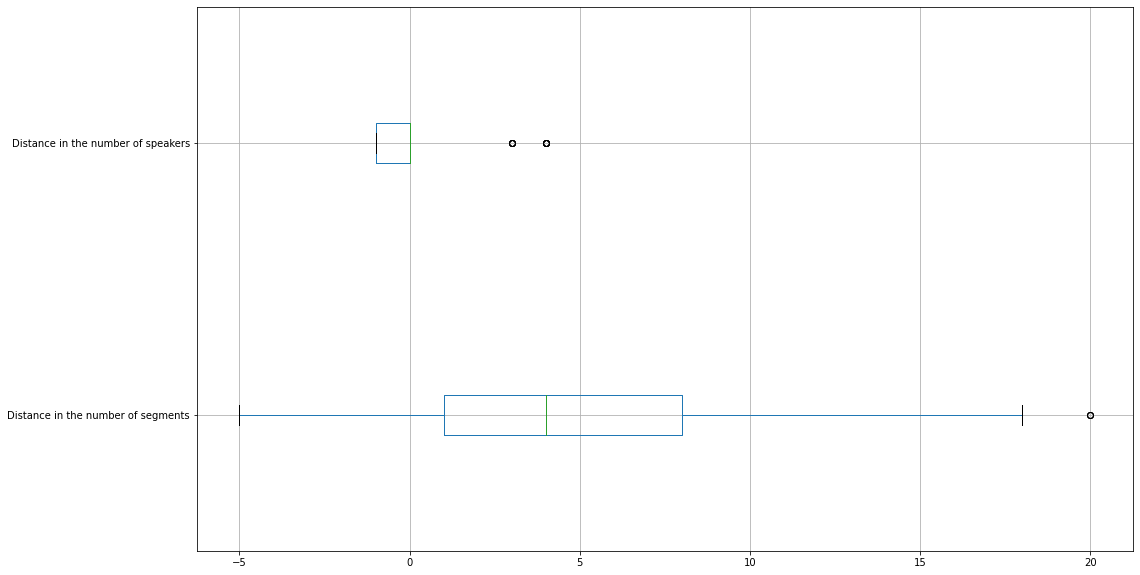

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
x = [list(new_df['distance'].values),
     list(new_df['speaker_distance'].values)]
df = pd.DataFrame(x, index=['Distance in the number of segments', 'Distance in the number of speakers'])


df.T.boxplot(vert=False, figsize=(20,10))
plt.subplots_adjust(left=0.25)
plt.show()